In [1]:
%%capture
pip install pysolar pvlib properscoring

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import os
import plotly.graph_objects as go
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import GRU, Dense, Flatten, LSTM, Conv1D, MaxPooling1D

from pysolar.solar import get_altitude, get_azimuth
from pvlib.location import Location
from pvlib.solarposition import get_solarposition
import pytz
import pvlib

from tensorflow_probability import distributions as tfd
from tensorflow_probability import layers as tfpl
import tensorflow as tf
from tensorflow.keras.layers import Input

import properscoring as ps
from scipy import stats


In [ ]:
from google.colab import files
files.upload()


Saving 91-Site_DKA-M9_B-Phase.csv to 91-Site_DKA-M9_B-Phase.csv
Buffered data was truncated after reaching the output size limit.

In [ ]:
import pandas as pd
from pvlib.solarposition import get_solarposition
from pvlib.location import Location  # Import Location from pvlib

# Load and preprocess data
df = pd.read_csv('91-Site_DKA-M9_B-Phase.csv')[['DateTime', 'ID003']]

# Convert 'DateTime' column to datetime format for proper time-based operations
df['DateTime'] = pd.to_datetime(df['DateTime'])

# Set 'DateTime' as the index for time series analysis
df.set_index('DateTime', inplace=True)

# Resample data to 1-hour intervals and calculate the mean for each period
df_resampled = df.resample('1h').mean()

# Handle missing values by filling them with the same timestamp from previous or future years
# Fill with previous year's same timestamp
df_resampled['ID003'] = df_resampled['ID003'].fillna(df_resampled['ID003'].shift(365))

# Fill with the same timestamp from two years ahead (next year)
df_resampled['ID003'] = df_resampled['ID003'].fillna(df_resampled['ID003'].shift(2 * 365))

# Fill with the same timestamp from one year ahead (next year)
df_resampled['ID003'] = df_resampled['ID003'].fillna(df_resampled['ID003'].shift(-2 * 365))

# Fill with the same timestamp from three years ahead
df_resampled['ID003'] = df_resampled['ID003'].fillna(df_resampled['ID003'].shift(3 * 365))

# Calculate solar zenith angle for Bellingwolde, Netherlands
location = Location(latitude=53.1218, longitude=7.1761, tz='UTC')
solar_position = get_solarposition(df_resampled.index, latitude=location.latitude, longitude=location.longitude)

# Add the solar zenith angle to the dataframe and filter based on zenith angle < 90
df_resampled['Solar_Zenith'] = solar_position['zenith']
df_filtered = df_resampled[df_resampled['Solar_Zenith'] < 90]

# Convert power from watts to kilowatts (divide by 1000)
df3 = df_filtered['ID003'] / 1000

# Rename the 'ID003' column to 'Power' for clarity
df3 = df3.rename('Power')

# Reset the index to make 'DateTime' a column again (useful for further analysis/plotting)
df3 = df3.reset_index()

df3




,DateTime,Power
0,2014-01-01 08:00:00+00:00,0.113426
1,2014-01-01 09:00:00+00:00,0.082476
2,2014-01-01 10:00:00+00:00,0.248086
3,2014-01-01 11:00:00+00:00,0.302245
4,2014-01-01 12:00:00+00:00,0.978818
...,...,...
17639,2017-12-31 11:00:00+00:00,0.058523
17640,2017-12-31 12:00:00+00:00,0.034736
17641,2017-12-31 13:00:00+00:00,0.030183
17642,2017-12-31 14:00:00+00:00,0.013303


In [ ]:
# Plot using Plotly for interactive visualization
fig = px.line(df3, x='DateTime', y='Power',
              title="Solar Power (kW) vs Time",
              labels={'Power': 'Power (kW)', 'DateTime': 'Time'},
              hover_data={'Power': True})

# Show the plot
fig.update_layout(
    xaxis_title="Time",
    yaxis_title="Power (kW)",
    hovermode="x unified"
)

fig.show()


In [ ]:


# Define split ranges for training, validation, and testing
train_start = "2014-01-01"
train_end = "2014-12-31"  # Train for 2014 and 2015
val_start = "2015-01-01"
val_end = "2015-12-31"    # Validation for 2016
test_start = "2017-01-01"
test_end = "2017-12-31"    # Test for 2017

# Split the data based on the defined ranges
train = df3.loc[train_start:train_end]
val = df3.loc[val_start:val_end]
test = df3.loc[test_start:test_end]

# Optional: Check the splits
print("Training Set:")
print(train.head())
print("\nValidation Set:")
print(val.head())
print("\nTest Set:")
print(test.head())


Training Set:
                              Power
DateTime                           
2014-01-01 08:00:00+00:00  0.113426
2014-01-01 09:00:00+00:00  0.082476
2014-01-01 10:00:00+00:00  0.248086
2014-01-01 11:00:00+00:00  0.302245
2014-01-01 12:00:00+00:00  0.978818

Validation Set:
                              Power
DateTime                           
2015-01-01 08:00:00+00:00  0.070368
2015-01-01 09:00:00+00:00  0.179382
2015-01-01 10:00:00+00:00  0.129509
2015-01-01 11:00:00+00:00  0.250460
2015-01-01 12:00:00+00:00  0.416598

Test Set:
                              Power
DateTime                           
2017-01-01 08:00:00+00:00  0.010932
2017-01-01 09:00:00+00:00  0.023381
2017-01-01 10:00:00+00:00  0.050439
2017-01-01 11:00:00+00:00  0.058365
2017-01-01 12:00:00+00:00  0.055571


In [ ]:
test

,Power
DateTime,
2017-01-01 08:00:00+00:00,0.010932
2017-01-01 09:00:00+00:00,0.023381
2017-01-01 10:00:00+00:00,0.050439
2017-01-01 11:00:00+00:00,0.058365
2017-01-01 12:00:00+00:00,0.055571
...,...
2017-12-31 11:00:00+00:00,0.058523
2017-12-31 12:00:00+00:00,0.034736
2017-12-31 13:00:00+00:00,0.030183


In [ ]:
# Define the seasons with their full months
spring = (test.index.month.isin([3, 4, 5]))  # Spring: March, April, May
summer = (test.index.month.isin([6, 7, 8]))  # Summer: June, July, August
autumn = (test.index.month.isin([9, 10, 11]))  # Autumn: September, October, November
winter = (test.index.month.isin([12, 1, 2]))  # Winter: December, January, February

# Split the test data into seasons
spring= test[spring]
summer = test[summer]
autumn= test[autumn]
winter = test[winter]



In [ ]:
summer

,Power
DateTime,
2017-06-01 04:00:00+00:00,0.039523
2017-06-01 05:00:00+00:00,0.085605
2017-06-01 06:00:00+00:00,0.134025
2017-06-01 07:00:00+00:00,0.417505
2017-06-01 08:00:00+00:00,1.144011
...,...
2017-08-31 14:00:00+00:00,1.197676
2017-08-31 15:00:00+00:00,1.129714
2017-08-31 16:00:00+00:00,0.812694


In [ ]:
# Scaling the data
scaler=MinMaxScaler().fit(train.values.reshape(-1, 1)) # Reshape 'train' to a 2D array
joblib.dump(scaler,'scaler.gz')

def scale_samples(data,scaler):
    data=scaler.transform(data.values.reshape(-1, 1)) # Reshape 'data' before transforming
    return data

train=scale_samples(train,scaler)
test=scale_samples(summer,scaler)
val=scale_samples(val,scaler)

In [ ]:
def shift_samples(data, lookback=48):
    data_x = []
    data_y = []
    for i in range(len(data) - int(lookback) - 1):
        x_floats = data[i:i+lookback, 0].reshape(-1, 1)  # Collect lookback samples for X, select 'power' column, and reshape
        y_floats = data[i+lookback:i+lookback+1, 0]  # Select only 'power' column for y
        data_x.append(x_floats)
        data_y.append(y_floats)
    return np.array(data_x), np.array(data_y).reshape(-1, 1)

# Prepare train, test, and validation datasets
x_train, y_train = shift_samples(train)  # No need to specify column since shift_samples now handles it
x_test, y_test = shift_samples(test)  # No need to specify column since shift_samples now handles it
x_val, y_val = shift_samples(val)  # No need to specify column since shift_samples now handles it
# Display final dataset shapes
print("Final datasets' shapes:")
print(f'X_train: {x_train.shape}, y_train: {y_train.shape}')
print(f'X_test: {x_test.shape}, y_test: {y_test.shape}')
print(f'X_val: {x_val.shape}, y_val: {y_val.shape}')

Final datasets' shapes:
X_train: (4361, 48, 1), y_train: (4361, 1)
X_test: (1376, 48, 1), y_test: (1376, 1)
X_val: (4361, 48, 1), y_val: (4361, 1)


Use pred_test for the Reliability Diagram because you need to assess how well the predicted quantiles match the observed frequencies.
Use y_pred_ensemble for CRPS because it aggregates all quantiles' predictions into a single set for probabilistic evaluation

In [ ]:
# Import necessary libraries
import numpy as np
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, GRU, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import joblib
import properscoring

# Backend for TensorFlow
from tensorflow.keras import backend as K

# Pinball loss function for a single quantile
def single_quantile_loss(tau=0.5):
    def loss(y_true, y_pred):
        err = y_true - y_pred
        return K.mean(K.maximum(tau * err, (tau - 1) * err), axis=-1)
    return loss

# Build the model with 20 quantiles including famous ones
quantiles = np.array([0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45,
                      0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95])

# Define the input layer
inputs = Input(shape=(x_train.shape[1], 1))  # The input shape should match the data dimensions

# Define the model architecture
x = Conv1D(22, 4, activation='relu', padding='same')(inputs)
x = MaxPooling1D(1)(x)
x = Conv1D(22, 4, activation='relu', padding='same')(x)  # Removed redundant input_shape argument
x = GRU(31, dropout=0.1)(x)
x = Flatten()(x)

# Output layer for 20 quantiles
outputs = {f'quantile_{tau:.2f}': Dense(1, name=f'quantile_{tau:.2f}')(x) for tau in quantiles}
model = keras.Model(inputs=inputs, outputs=outputs)

# Compile the model with loss for each quantile
model.compile(loss={f'quantile_{tau:.2f}': single_quantile_loss(tau) for tau in quantiles}, optimizer='adam')

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Define x_test and y_test before testing the model
x_test, y_test = shift_samples(test)

# Model fitting
history2 = model.fit(
    x_train,
    {f'quantile_{tau:.2f}': y_train for tau in quantiles},
    validation_data=(x_val, {f'quantile_{tau:.2f}': y_val for tau in quantiles}),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1,
    shuffle=False
)

# Prediction and inverse transform for the test set
pred_test = model.predict(x_test)  # Call predict on the model, not on individual layers

# Scaler setup
scaler_power = MinMaxScaler().fit(train[:, 0].reshape(-1, 1))  # Fit the scaler to train values

nominal_power_kW = 2.250  # Capacity for bill in kW

# Inverse transform for each quantile and normalize by nominal power
pred_test = {tau: scaler_power.inverse_transform(pred_test[f'quantile_{tau:.2f}']) / nominal_power_kW for tau in quantiles}
y_test = scaler_power.inverse_transform(y_test.reshape(-1, 1)) / nominal_power_kW

# Prepare the ensemble of predictions (quantiles) for CRPS
y_pred_ensemble = np.column_stack([pred_test[tau].flatten() for tau in quantiles])

# Calculate CRPS scores using properscoring
crps_scores = properscoring.crps_ensemble(np.nan_to_num(y_test.flatten()), np.nan_to_num(y_pred_ensemble))

# Output the normalized CRPS score
print("Normalized CRPS Score for each sample:", crps_scores)

# Calculate and print the mean normalized CRPS
mean_crps = np.mean(crps_scores)
print("Mean Normalized CRPS Score:", mean_crps)


Epoch 1/30
137/137 ━━━━━━━━━━━━━━━━━━━━ 32s 55ms/step - loss: 1.4010 - quantile_0.01_loss: 0.0028 - quantile_0.05_loss: 0.0131 - quantile_0.10_loss: 0.0263 - quantile_0.15_loss: 0.0377 - quantile_0.20_loss: 0.0531 - quantile_0.25_loss: 0.0539 - quantile_0.30_loss: 0.0633 - quantile_0.35_loss: 0.0747 - quantile_0.40_loss: 0.0776 - quantile_0.45_loss: 0.0853 - quantile_0.50_loss: 0.0977 - quantile_0.55_loss: 0.0987 - quantile_0.60_loss: 0.0980 - quantile_0.65_loss: 0.1027 - quantile_0.70_loss: 0.1016 - quantile_0.75_loss: 0.0981 - quantile_0.80_loss: 0.0863 - quantile_0.85_loss: 0.0862 - quantile_0.90_loss: 0.0917 - quantile_0.95_loss: 0.0522 - val_loss: 1.0471 - val_quantile_0.01_loss: 0.0029 - val_quantile_0.05_loss: 0.0132 - val_quantile_0.10_loss: 0.0244 - val_quantile_0.15_loss: 0.0341 - val_quantile_0.20_loss: 0.0416 - val_quantile_0.25_loss: 0.0446 - val_quantile_0.30_loss: 0.0552 - val_quantile_0.35_loss: 0.0620 - val_quantile_0.40_loss: 0.0651 - val_quantile_0.45_loss: 0.0694 - 

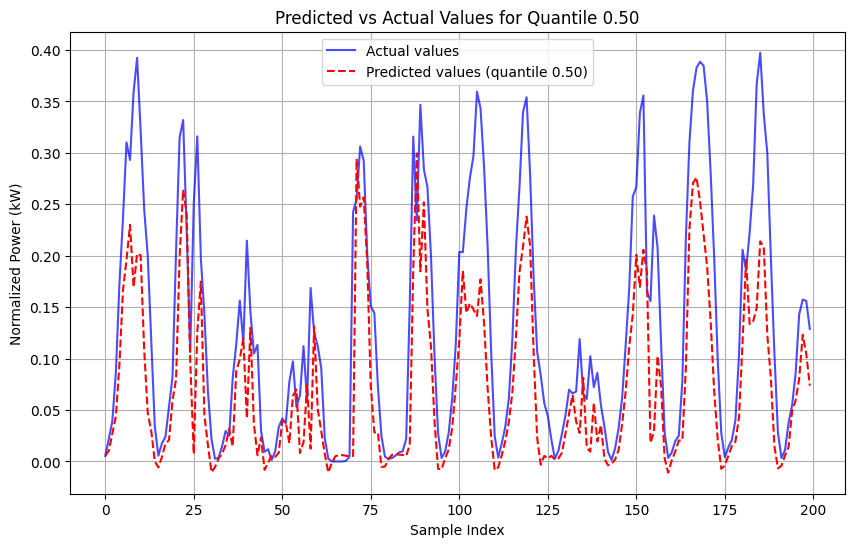

In [ ]:
import matplotlib.pyplot as plt

# Select a specific quantile for visualization
quantile_to_plot = 0.5  # Choose the quantile to plot (e.g., 0.5 for the median)

# Retrieve the predicted values for the selected quantile
predicted_values = pred_test[quantile_to_plot]

# Select a subset of the data for better visualization (e.g., first 100 data points)
subset_size = 200
y_test_subset = y_test[:subset_size]
predicted_values_subset = predicted_values[:subset_size]

# Plot actual vs predicted values for the subset
plt.figure(figsize=(10, 6))
plt.plot(y_test_subset, label='Actual values', color='blue', alpha=0.7)
plt.plot(predicted_values_subset, label=f'Predicted values (quantile {quantile_to_plot:.2f})', color='red', linestyle='--')
plt.title(f'Predicted vs Actual Values for Quantile {quantile_to_plot:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('Normalized Power (kW)')
plt.legend()
plt.grid(True)
plt.show()


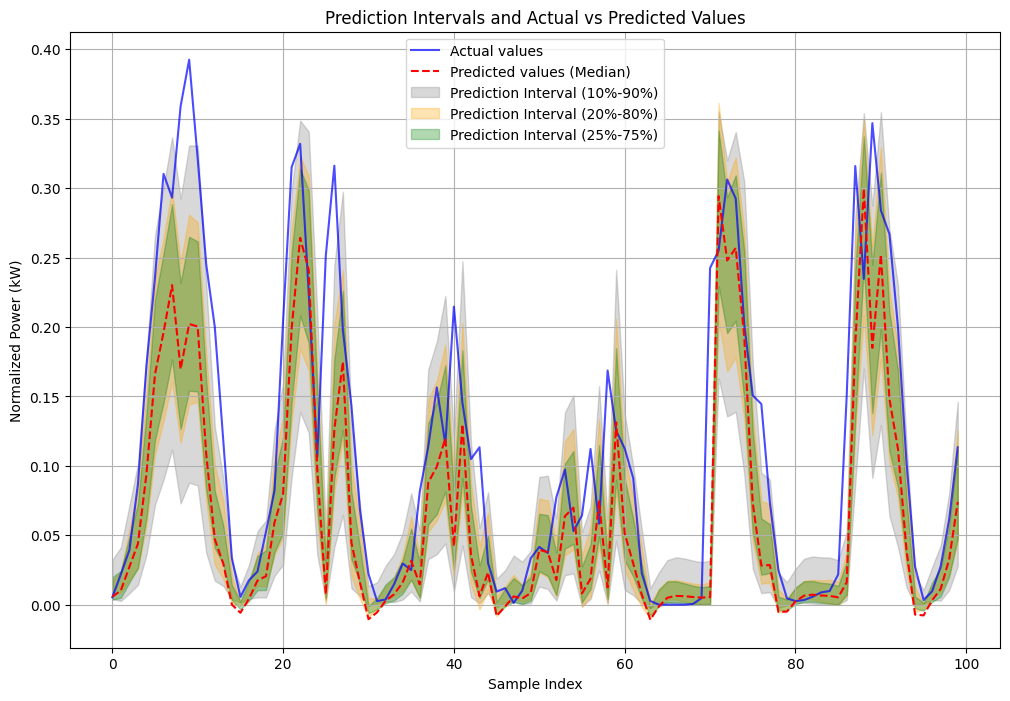

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Convert predictions back to original scale (inverse transform)
pred_lower = scaler_power.inverse_transform(predicted_lower) / nominal_power_kW # Change pred_lower to predicted_lower
pred_upper = scaler_power.inverse_transform(predicted_upper) / nominal_power_kW # Change pred_upper to predicted_upper
pred_median = scaler_power.inverse_transform(predicted_median) / nominal_power_kW # Change pred_median to predicted_median
y_test_original = scaler_power.inverse_transform(y_test.reshape(-1, 1)) / nominal_power_kW

# Build the model with 20 quantiles including famous ones
quantiles = np.array([0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45,
                      0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95])

# Select a subset of the data for better visualization (e.g., first 100 data points)
subset_size = 100
y_test_subset = y_test[:subset_size].flatten()  # Flatten y_test_subset

# Define intervals by quantile ranges
quantile_lower_10_90 = 0.10  # Lower bound for 10%-90% interval
quantile_upper_10_90 = 0.90  # Upper bound for 10%-90% interval

quantile_lower_20_80 = 0.20  # Lower bound for 20%-80% interval
quantile_upper_20_80 = 0.80  # Upper bound for 20%-80% interval

quantile_lower_25_75 = 0.25  # Lower bound for 25%-75% interval
quantile_upper_25_75 = 0.75  # Upper bound for 25%-75% interval

# Retrieve the predicted values for the specified quantiles from pred_test
predicted_lower_10_90 = pred_test[round(quantile_lower_10_90, 2)]  # Round to 2 decimal places for matching
predicted_upper_10_90 = pred_test[round(quantile_upper_10_90, 2)]  # Round to 2 decimal places for matching

predicted_lower_20_80 = pred_test[round(quantile_lower_20_80, 2)]  # Round to 2 decimal places for matching
predicted_upper_20_80 = pred_test[round(quantile_upper_20_80, 2)]  # Round to 2 decimal places for matching

predicted_lower_25_75 = pred_test[round(quantile_lower_25_75, 2)]  # Round to 2 decimal places for matching
predicted_upper_25_75 = pred_test[round(quantile_upper_25_75, 2)]  # Round to 2 decimal places for matching

# Select subset for each interval
predicted_lower_10_90_subset = predicted_lower_10_90[:subset_size].flatten()
predicted_upper_10_90_subset = predicted_upper_10_90[:subset_size].flatten()

predicted_lower_20_80_subset = predicted_lower_20_80[:subset_size].flatten()
predicted_upper_20_80_subset = predicted_upper_20_80[:subset_size].flatten()

predicted_lower_25_75_subset = predicted_lower_25_75[:subset_size].flatten()
predicted_upper_25_75_subset = predicted_upper_25_75[:subset_size].flatten()

# Plot actual vs predicted values and the prediction intervals
plt.figure(figsize=(12, 8))

# Plot actual values
plt.plot(y_test_subset, label='Actual values', color='blue', alpha=0.7)

# Plot the median prediction (50th quantile)
plt.plot(predicted_median_subset, label='Predicted values (Median)', color='red', linestyle='--')

# Fill the area between the lower and upper quantiles to show the prediction interval
plt.fill_between(range(subset_size), predicted_lower_10_90_subset, predicted_upper_10_90_subset,
                 color='gray', alpha=0.3, label='Prediction Interval (10%-90%)')

plt.fill_between(range(subset_size), predicted_lower_20_80_subset, predicted_upper_20_80_subset,
                 color='orange', alpha=0.3, label='Prediction Interval (20%-80%)')

plt.fill_between(range(subset_size), predicted_lower_25_75_subset, predicted_upper_25_75_subset,
                 color='green', alpha=0.3, label='Prediction Interval (25%-75%)')

# Title and labels
plt.title('Prediction Intervals and Actual vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Normalized Power (kW)')
plt.legend()
plt.grid(True)
plt.show()


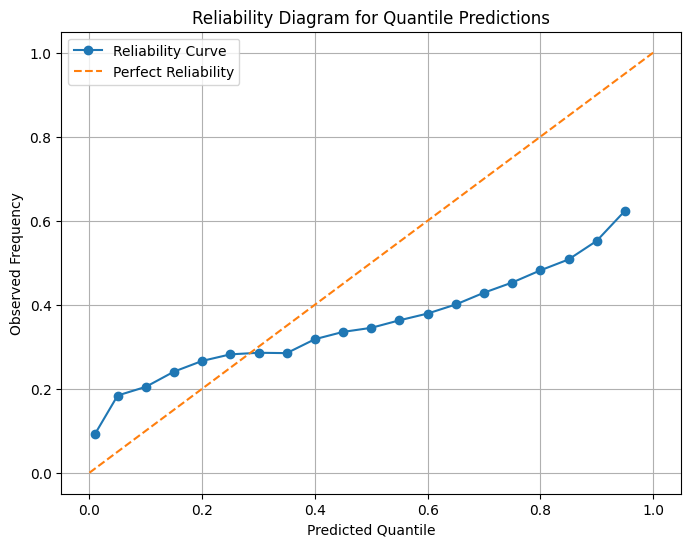

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming pred_test contains the quantile predictions as numerical keys
# Example: pred_test = {0.01: array([...]), 0.05: array([...]), ...}

# Define the quantiles used (the same ones in pred_test)
quantiles = np.array([0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45,
                      0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95])

# Convert predictions for each quantile
pred_quantiles = [pred_test[tau] for tau in quantiles]  # Access predictions using numeric keys

# Reshape y_test for comparison
y_test_flattened = y_test.flatten()

# Prepare the reliability data
reliability_data = []

# Iterate through the quantiles and calculate observed frequencies
for tau, pred in zip(quantiles, pred_quantiles):
    # Calculate the observed frequency (fraction of y_test <= the predicted quantile)
    observed_frequency = np.mean((y_test_flattened <= pred))
    reliability_data.append((tau, observed_frequency))

# Convert reliability data to numpy array
reliability_data = np.array(reliability_data)

# Plot the reliability diagram
plt.figure(figsize=(8, 6))
plt.plot(reliability_data[:, 0], reliability_data[:, 1], label='Reliability Curve', marker='o')

# Add the diagonal line representing perfect reliability
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Reliability')

# Labels and title
plt.title('Reliability Diagram for Quantile Predictions')
plt.xlabel('Predicted Quantile')
plt.ylabel('Observed Frequency')
plt.legend(loc='best')
plt.grid(True)

# Display the plot
plt.show()


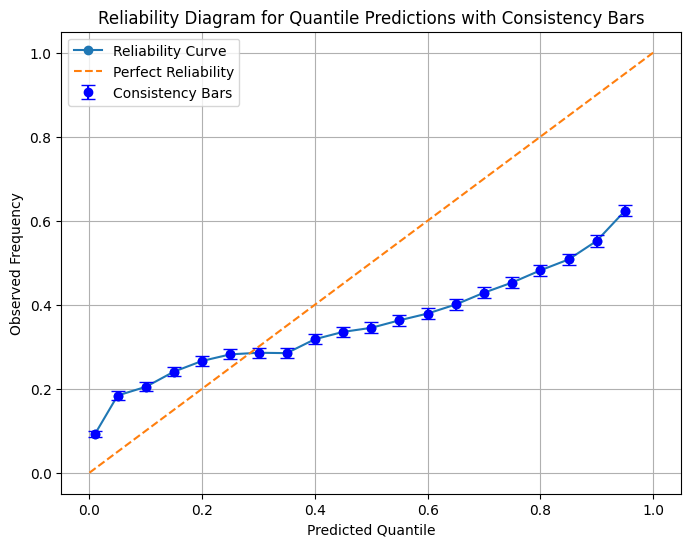

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming pred_test contains the quantile predictions as numerical keys
# Example: pred_test = {0.01: array([...]), 0.05: array([...]), ...}

# Define the quantiles used (the same ones in pred_test)
quantiles = np.array([0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45,
                      0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95])

# Convert predictions for each quantile
pred_quantiles = [pred_test[tau] for tau in quantiles]  # Access predictions using numeric keys

# Reshape y_test for comparison
y_test_flattened = y_test.flatten()

# Prepare the reliability data
reliability_data = []
observed_frequencies = []

# Iterate through the quantiles and calculate observed frequencies
for tau, pred in zip(quantiles, pred_quantiles):
    # Calculate the observed frequency (fraction of y_test <= the predicted quantile)
    observed_frequency = np.mean((y_test_flattened <= pred))

    # Calculate the standard deviation for observed frequencies for consistency
    # This will give the consistency error (standard error)
    consistency_error = np.std((y_test_flattened <= pred)) / np.sqrt(len(y_test_flattened))  # Standard error
    reliability_data.append((tau, observed_frequency))
    observed_frequencies.append(consistency_error)

# Convert reliability data to numpy array
reliability_data = np.array(reliability_data)
observed_frequencies = np.array(observed_frequencies)

# Plot the reliability diagram
plt.figure(figsize=(8, 6))
plt.plot(reliability_data[:, 0], reliability_data[:, 1], label='Reliability Curve', marker='o')

# Add the diagonal line representing perfect reliability
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Reliability')

# Add error bars for consistency
plt.errorbar(reliability_data[:, 0], reliability_data[:, 1], yerr=observed_frequencies, fmt='o', color='blue', capsize=5, label='Consistency Bars')

# Labels and title
plt.title('Reliability Diagram for Quantile Predictions with Consistency Bars')
plt.xlabel('Predicted Quantile')
plt.ylabel('Observed Frequency')
plt.legend(loc='best')
plt.grid(True)

# Display the plot
plt.show()


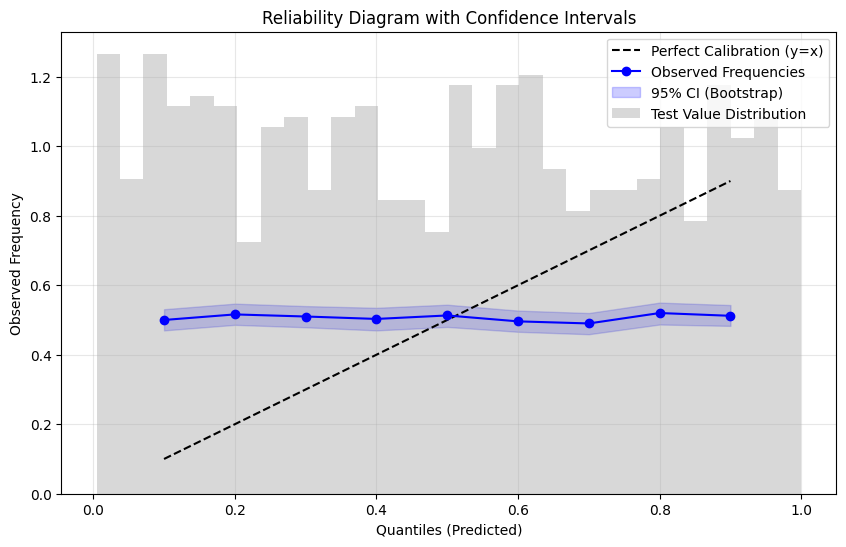

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample

# Function to calculate observed frequencies and bootstrap confidence intervals
def calculate_reliability(y_test, pred_test, quantiles, n_bootstrap=1000):
    observed_frequencies = []
    lower_bounds = []
    upper_bounds = []

    for q in quantiles:
        pred = pred_test[q]
        # Calculate observed frequency for this quantile
        obs_freq = np.mean(y_test <= pred)
        observed_frequencies.append(obs_freq)

        # Bootstrap for confidence intervals
        bootstrap_freqs = []
        for _ in range(n_bootstrap):
            y_test_boot, pred_boot = resample(y_test, pred)
            bootstrap_freqs.append(np.mean(y_test_boot <= pred_boot))

        # Calculate 95% confidence interval
        lower = np.percentile(bootstrap_freqs, 2.5)
        upper = np.percentile(bootstrap_freqs, 97.5)
        lower_bounds.append(lower)
        upper_bounds.append(upper)

    return observed_frequencies, lower_bounds, upper_bounds

# Generate sample data (replace with your own y_test and pred_test)
np.random.seed(42)
y_test = np.random.rand(1000)  # True values
quantiles = np.linspace(0.1, 0.9, 9)  # Quantile levels
pred_test = {q: np.random.rand(1000) for q in quantiles}  # Replace with your model's predictions

# Calculate reliability and confidence intervals
observed_frequencies, lower_bounds, upper_bounds = calculate_reliability(y_test, pred_test, quantiles)

# Plot reliability diagram
plt.figure(figsize=(10, 6))
plt.plot(quantiles, quantiles, label="Perfect Calibration (y=x)", linestyle="--", color="black")
plt.plot(quantiles, observed_frequencies, label="Observed Frequencies", marker="o", color="blue")
plt.fill_between(quantiles, lower_bounds, upper_bounds, color="blue", alpha=0.2, label="95% CI (Bootstrap)")

# Overlay histogram for test values
plt.hist(y_test, bins=30, alpha=0.3, color="gray", density=True, label="Test Value Distribution")

# Add labels and legend
plt.xlabel("Quantiles (Predicted)")
plt.ylabel("Observed Frequency")
plt.title("Reliability Diagram with Confidence Intervals")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


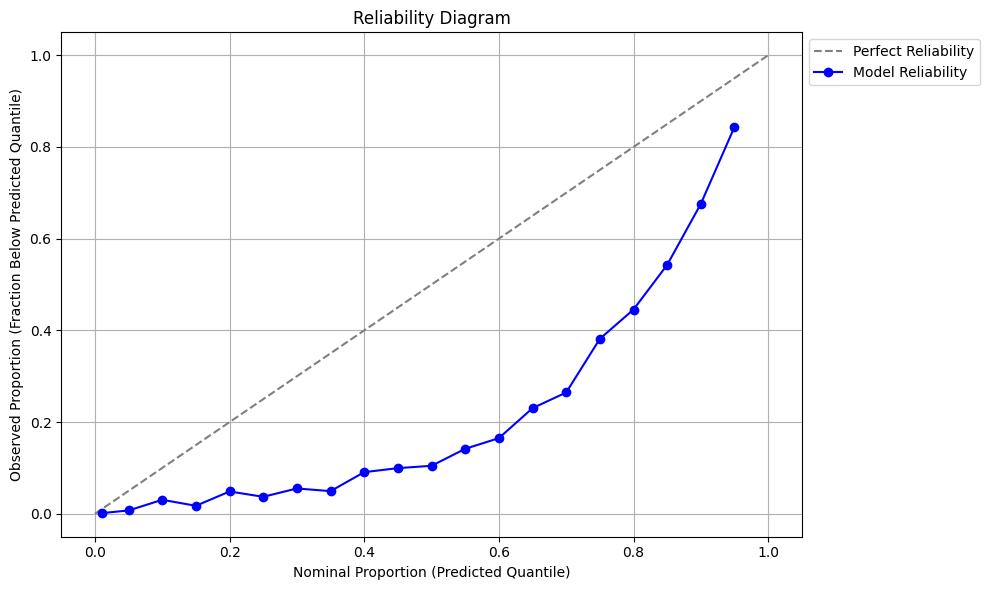

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Number of bins for the reliability diagram (adjust this for your needs)
n_bins = 10

# Create a list to store observed proportions for each quantile
observed_proportions = []

# Loop through each quantile and calculate the observed proportion
for tau in quantiles:
    quantile_key = tau  # Quantile key corresponds to the tau value
    predicted_values = pred_test[quantile_key].flatten()  # Predicted quantile values

    # Calculate observed proportion: fraction of actuals <= predicted quantile
    observed_proportion = np.mean(y_test.flatten() <= predicted_values)
    observed_proportions.append(observed_proportion)

# Convert list to a numpy array for convenience
observed_proportions = np.array(observed_proportions)

# Plot the reliability diagram
plt.figure(figsize=(10, 6))

# Plot the perfect reliability line (y = x)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Reliability')

# Plot the model reliability curve
plt.plot(quantiles, observed_proportions, marker='o', label='Model Reliability', color='blue')

# Add labels, title, and legend
plt.title('Reliability Diagram')
plt.xlabel('Nominal Proportion (Predicted Quantile)')
plt.ylabel('Observed Proportion (Fraction Below Predicted Quantile)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

# Adjust layout to prevent overlap with the legend
plt.tight_layout()
plt.show()


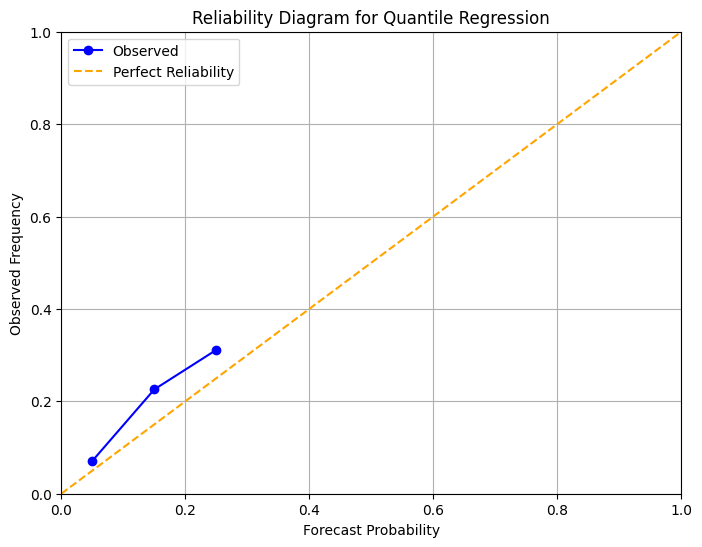

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class ReliabilityDiagram:
    def __init__(self, observation, forecast, nbins=10):
        """
        Initialize the Reliability Diagram for Quantile Regression.

        Args:
            observation (np.ndarray): Ground truth values.
            forecast (np.ndarray): Predicted median values from quantile regression.
            nbins (int): Number of bins for calibration.
        """
        self.observation = observation.flatten()
        self.forecast = forecast.flatten()
        self.nbins = nbins
        self.bins = np.linspace(0, 1, self.nbins + 1)

    def observed_frequency(self):
        """
        Calculate the observed frequency for each bin.
        Handles zero-count bins by replacing them with NaN.

        Returns:
            np.ndarray: Observed frequencies for each bin.
        """
        # Calculate the bin counts and weighted observations
        bin_counts = np.histogram(self.forecast, bins=self.bins)[0]
        obs_sum = np.histogram(self.forecast, bins=self.bins, weights=self.observation)[0]

        # Avoid division by zero
        with np.errstate(divide='ignore', invalid='ignore'):
            obs_freq = np.divide(obs_sum, bin_counts)
            obs_freq[bin_counts == 0] = np.nan  # Set zero-count bins to NaN

        return obs_freq

    def plot(self):
        """
        Plot the reliability diagram.
        """
        obs_freq = self.observed_frequency()

        # Midpoints of bins for plotting
        bin_centers = self.bins[:-1] + 0.5 * (self.bins[1] - self.bins[0])

        plt.figure(figsize=(8, 6))
        plt.plot(bin_centers, obs_freq, label="Observed", marker="o", color="blue")
        plt.plot([0, 1], [0, 1], linestyle="--", color="orange", label="Perfect Reliability")
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.xlabel("Forecast Probability")
        plt.ylabel("Observed Frequency")
        plt.title("Reliability Diagram for Quantile Regression")
        plt.legend()
        plt.grid()
        plt.show()

# Example Usage
reliability_diagram = ReliabilityDiagram(
    observation=y_test,
    forecast=y_pred_ensemble.mean(axis=1),
    nbins=10
)
reliability_diagram.plot()

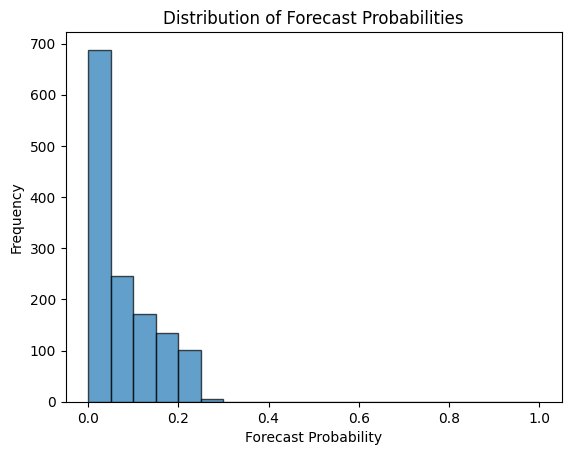

In [ ]:
plt.hist(y_pred_ensemble.mean(axis=1), bins=20, range=(0, 1), alpha=0.7, edgecolor="black")
plt.xlabel("Forecast Probability")
plt.ylabel("Frequency")
plt.title("Distribution of Forecast Probabilities")
plt.show()


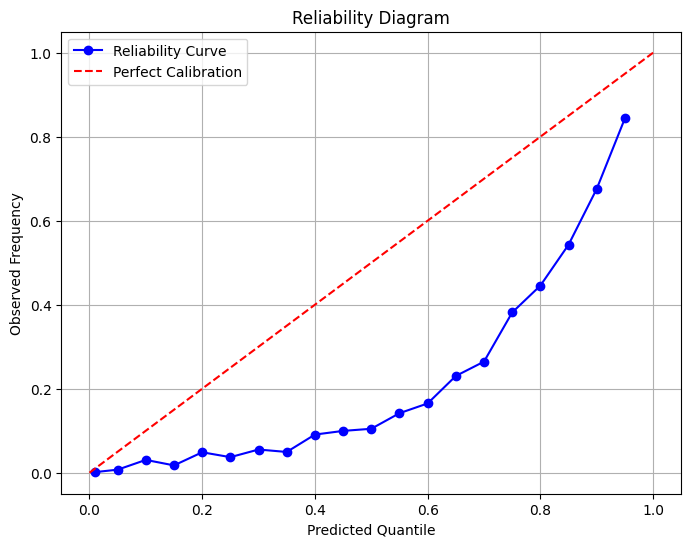

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate the reliability (empirical cumulative distribution function)
def reliability_diagram(y_true, y_pred, quantiles):
    observed_freq = []
    predicted_quantiles = []

    for i, tau in enumerate(quantiles):
        # Calculate the predicted quantile (indexing the predictions array correctly)
        predicted_value = y_pred[:, i]  # Use the index 'i' for the respective quantile

        # Compute the observed frequency (proportion of actual values below the predicted quantile)
        observed = np.mean(y_true <= predicted_value)

        observed_freq.append(observed)
        predicted_quantiles.append(tau)

    return predicted_quantiles, observed_freq
# Build the model with 20 quantiles including famous ones
quantiles = np.array([0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45,
                      0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95])



# Prepare the true and predicted values (reshaped as necessary)
y_test_flat = np.nan_to_num(y_test.flatten())  # Ensure no NaN values in the true data
y_pred_ensemble_flat = np.column_stack([pred_test[tau].flatten() for tau in quantiles])  # Flatten each quantile prediction

# Calculate the reliability diagram values
reliability_quantiles, reliability_frequencies = reliability_diagram(y_test_flat, y_pred_ensemble_flat, quantiles)

# Plot the reliability diagram
plt.figure(figsize=(8, 6))
plt.plot(reliability_quantiles, reliability_frequencies, label='Reliability Curve', marker='o', linestyle='-', color='blue')
plt.plot([0, 1], [0, 1], label='Perfect Calibration', linestyle='--', color='red')  # The ideal line (perfect calibration)
plt.xlabel('Predicted Quantile')
plt.ylabel('Observed Frequency')
plt.title('Reliability Diagram')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print("y_test shape:", y_test.shape)
print("y_pred_ensemble shape:", y_pred_ensemble.shape)


y_test shape: (1376, 1)
y_pred_ensemble shape: (1376, 20)


<ipython-input-144-c156530205c8>:11: RuntimeWarning:

invalid value encountered in divide



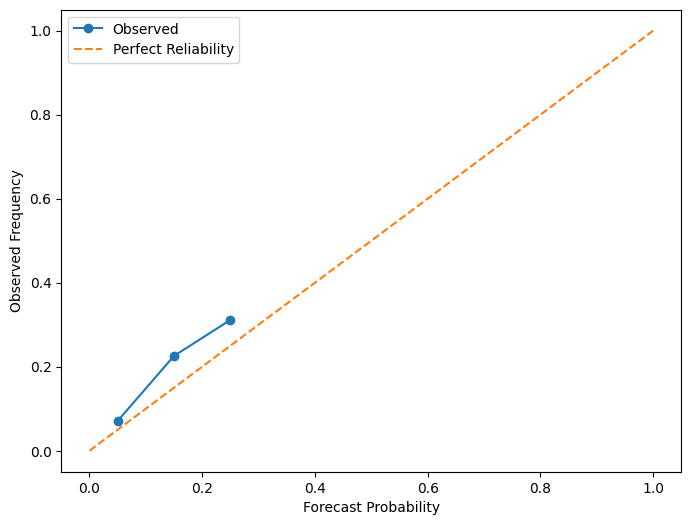

In [ ]:
class ReliabilityDiagram:
    def __init__(self, observation, forecast, nbins=10):
        self.observation = observation.flatten()
        self.forecast = forecast.flatten()
        self.nbins = nbins
        self.bins = np.linspace(0, 1, self.nbins + 1)

    def observed_frequency(self):
        bin_counts = np.histogram(self.forecast, bins=self.bins)[0]
        obs_sum = np.histogram(self.forecast, bins=self.bins, weights=self.observation)[0]
        return obs_sum / bin_counts

    def plot(self):
        obs_freq = self.observed_frequency()
        plt.figure(figsize=(8, 6))
        plt.plot(self.bins[:-1] + 0.5 / self.nbins, obs_freq, label="Observed", marker="o")
        plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect Reliability")
        plt.xlabel("Forecast Probability")
        plt.ylabel("Observed Frequency")
        plt.legend()
        plt.show()

# Instantiate and use Reliability Diagram
reliability_diagram = ReliabilityDiagram(observation=y_test, forecast=y_pred_ensemble.mean(axis=1), nbins=10)
reliability_diagram.plot()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_reliability_diagram(y_true, y_pred, quantiles):
    """
    Plots a reliability diagram comparing normal proportions (predicted quantiles)
    against observed proportions.

    Parameters:
        y_true (array-like): True target values.
        y_pred (dict): Dictionary of predicted quantile values, keyed by quantile levels.
        quantiles (list or array-like): List of quantile levels.
    """
    # Ensure y_true and y_pred are NumPy arrays for consistent handling
    y_true = np.asarray(y_true).flatten()

    # Check if y_pred is a dictionary with valid quantiles
    if not isinstance(y_pred, dict):
        raise ValueError("y_pred must be a dictionary with quantile levels as keys.")

    if not all(tau in y_pred for tau in quantiles):
        raise ValueError("All quantiles in the list must have corresponding predictions in y_pred.")

    plt.figure(figsize=(10, 6))

    for tau in quantiles:
        predicted_quantile = np.asarray(y_pred[tau]).flatten()

        # Avoid errors from empty predictions
        if len(predicted_quantile) == 0:
            raise ValueError(f"No predictions found for quantile {tau}.")

        # Calculate observed proportions as the frequency of values ≤ predicted quantile
        observed_proportion = [np.mean(y_true <= q) for q in predicted_quantile]

        # Sort predicted quantiles for smoother plotting
        sorted_predicted = np.sort(predicted_quantile)
        sorted_observed = np.array(observed_proportion)[np.argsort(predicted_quantile)]

        # Plot normal proportion (predicted quantiles) against observed proportion
        plt.plot(sorted_predicted, sorted_observed, label=f'Quantile {tau:.2f}')

    # Add reference line for perfect reliability
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect Reliability', linewidth=1.5)
    plt.xlabel('Normal Proportion (Predicted Quantile)')
    plt.ylabel('Observed Proportion')
    plt.title('Reliability Diagram for Quantile Predictions')
    plt.legend(loc='upper left')
    plt.grid(alpha=0.6)
    plt.tight_layout()
    plt.show()

# Example usage
# Ensure you provide valid data for y_test and pred_test
# y_test should be a 1D NumPy array of true values
# pred_test should be a dictionary with quantile predictions (keyed by quantile levels)

plot_reliability_diagram(
    y_true=y_test.flatten(),
    y_pred=pred_test,
    quantiles=quantiles
)


ValueError: All quantiles in the list must have corresponding predictions in y_pred.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the quantiles you are using
quantiles = np.array([0.01, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45,
                      0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95])

# Use your quantile predictions (e.g., pred_test) for the reliability diagram
# Here, we will use the 0.05, 0.50, and 0.95 quantiles for illustration

pred_quantiles = np.array([pred_test[f'quantile_{tau:.2f}'] for tau in quantiles])

# Reshape the predictions and actual values
y_test_flattened = y_test.flatten()

# Prepare the reliability diagram
reliability_data = []

for tau, pred in zip(quantiles, pred_quantiles):
    # Calculate the observed frequencies for each quantile range
    # For example, use the predicted quantile as the threshold
    observed_frequency = np.mean((y_test_flattened <= pred))  # Fraction of actual values <= predicted quantile
    reliability_data.append((tau, observed_frequency))

# Convert to numpy array for easier manipulation
reliability_data = np.array(reliability_data)

# Plot the reliability diagram
plt.figure(figsize=(8, 6))
plt.plot(reliability_data[:, 0], reliability_data[:, 1], label='Reliability Curve', marker='o')

# Add the diagonal line representing perfect reliability (ideal calibration)
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Reliability')

# Labels and title
plt.title('Reliability Diagram for Quantile Predictions')
plt.xlabel('Predicted Quantile')
plt.ylabel('Observed Frequency')
plt.legend(loc='best')
plt.grid(True)

# Display the plot
plt.show()


KeyError: 'quantile_0.01'

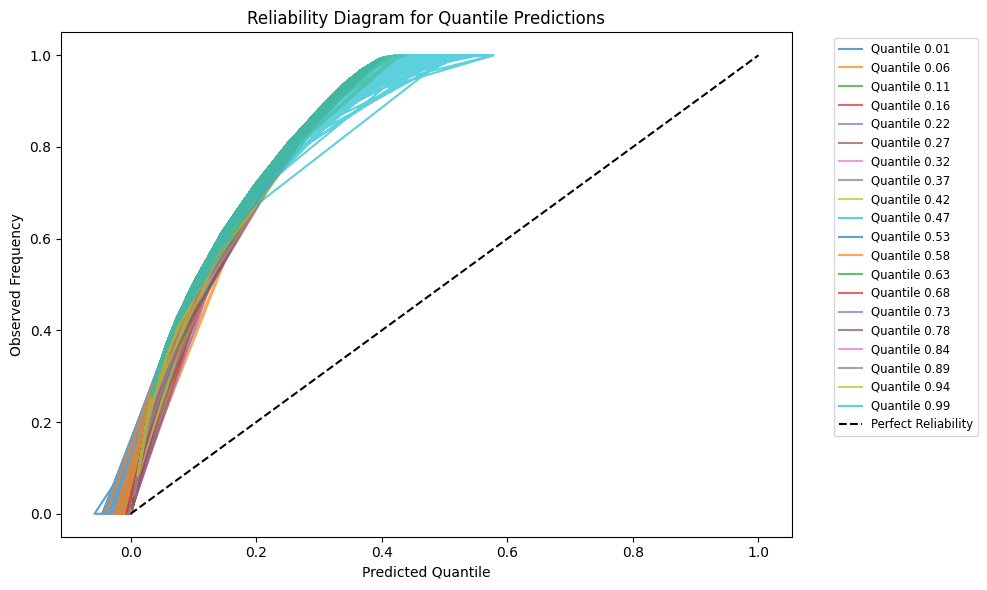

In [ ]:
def plot_reliability_diagram(y_true, y_pred, quantiles):

    import matplotlib.pyplot as plt
    import numpy as np

    plt.figure(figsize=(10, 6))

    # Normalize y_pred keys to floats
    y_pred_normalized = {float(tau): y_pred[tau] for tau in y_pred}

    for tau in quantiles:
        # Access the predicted quantile values safely
        if tau not in y_pred_normalized:
            print(f"Quantile {tau} not found in y_pred. Skipping.")
            continue

        predicted_quantile = y_pred_normalized[tau].flatten()
        observed_frequency = [np.mean(y_true <= q) for q in predicted_quantile]

        plt.plot(
            predicted_quantile,
            observed_frequency,
            label=f'Quantile {tau:.2f}',
            alpha=0.7
        )

    # Add the perfect reliability line
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect Reliability')

    # Add labels, title, and legend
    plt.xlabel('Predicted Quantile')
    plt.ylabel('Observed Frequency')
    plt.title('Reliability Diagram for Quantile Predictions')
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='small')
    plt.tight_layout()
    plt.show()
# Example Usage
plot_reliability_diagram(
    y_true=y_test.flatten(),
    y_pred=pred_test,
    quantiles=quantiles
)

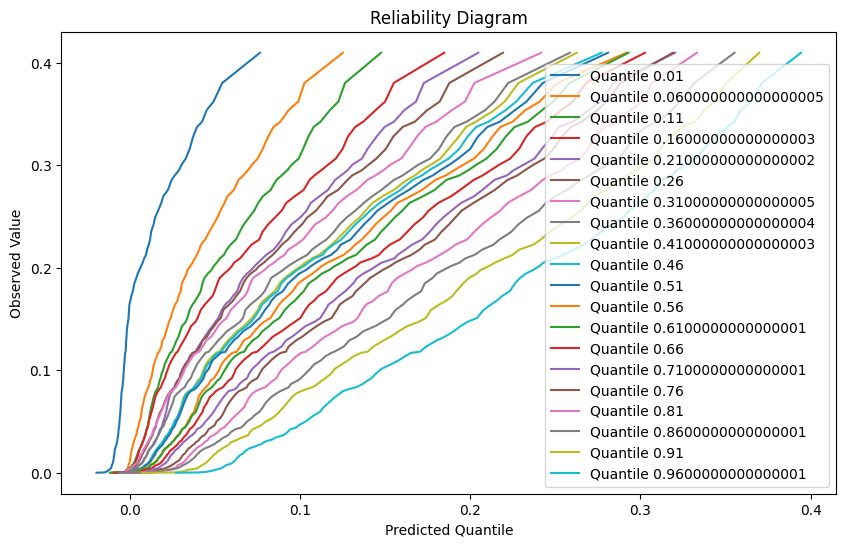

In [ ]:
import matplotlib.pyplot as plt

def plot_reliability_diagram(y_true, y_pred, quantiles):
    plt.figure(figsize=(10, 6))
    for tau in quantiles:
        # Compute reliability for each quantile
        pred_quantile = y_pred[tau]
        observed = np.mean(y_true <= pred_quantile) #Calculate the observed frequency

        # Plot reliability diagram
        plt.plot(np.percentile(pred_quantile, np.arange(0, 101, 1)), np.percentile(y_true, np.arange(0, 101, 1)), label=f'Quantile {tau}') #Use percentiles of y_true for the y-axis

    plt.xlabel('Predicted Quantile')
    plt.ylabel('Observed Value')
    plt.title('Reliability Diagram')
    plt.legend()
    plt.show()

# Example usage
plot_reliability_diagram(y_test, pred_test, quantiles)

In [ ]:
# Load and preprocess data
df = pd.read_csv('filtered_ac.csv')[['DateTime', 'ID003']]
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index('DateTime', inplace=True)

# Resample to 15-minute intervals
df_resampled = df.resample('15T').mean()

# Calculate solar zenith angle for Bellingwolde, Netherlands
location = Location(latitude=53.1218, longitude=7.1761, tz='UTC')
solar_position = get_solarposition(df_resampled.index, latitude=location.latitude, longitude=location.longitude)

# Add solar zenith angle and filter based on zenith angle
df_resampled['Solar_Zenith'] = solar_position['zenith']
df_filtered = df_resampled[df_resampled['Solar_Zenith'] < 90]

# Output the filtered photovoltaic power
df3 = df_filtered['ID003']
from sklearn.impute import KNNImputer

# Initialize the imputer
imputer = KNNImputer(n_neighbors=5)

# Reshape df3 to a 2D array before imputation
df3_reshaped = df3.values.reshape(-1, 1)  # Reshape to a column vector

# Fit and transform the reshaped data
df3_imputed = imputer.fit_transform(df3_reshaped)

# Convert the imputed data back to a Series
df3 = pd.Series(df3_imputed.flatten(), index=df3.index)
df3 = df3.rename('Power')


# Sort the data chronologically
df3 = df3.sort_index()

# Define split ranges
train_start = "2014-01-01"
train_end = "2014-12-31"  # Train: 2014 and 2015
val_start = "2015-01-01"
val_end = "2015-12-31"  # Validation: 2016
test_start = "2017-01-01"
test_end = "2017-12-31"  # Test: 2017

# Create splits
train= df3[(df3.index >= train_start) & (df3.index <= train_end)]
val = df3[(df3.index >= val_start) & (df3.index <= val_end)]
test = df3[(df3.index >= test_start) & (df3.index <= test_end)]
# Define the seasons with their full months
spring = (test.index.month.isin([3, 4, 5]))  # Spring: March, April, May
summer = (test.index.month.isin([6, 7, 8]))  # Summer: June, July, August
autumn = (test.index.month.isin([9, 10, 11]))  # Autumn: September, October, November
winter = (test.index.month.isin([12, 1, 2]))  # Winter: December, January, February

# Split the test data into seasons
spring= test[spring]
summer = test[summer]
autumn= test[autumn]
winter = test[winter]


# Scaling the data
scaler=MinMaxScaler().fit(train.values.reshape(-1, 1)) # Reshape 'train' to a 2D array
joblib.dump(scaler,'scaler.gz')

def scale_samples(data,scaler):
    data=scaler.transform(data.values.reshape(-1, 1)) # Reshape 'data' before transforming
    return data

train=scale_samples(train,scaler)
test=scale_samples(summer,scaler)
val=scale_samples(val,scaler)
def shift_samples(data, lookback=15):
    data_x = []
    data_y = []
    for i in range(len(data) - int(lookback) - 1):
        x_floats = data[i:i+lookback, 0].reshape(-1, 1)  # Collect lookback samples for X, select 'power' column, and reshape
        y_floats = data[i+lookback:i+lookback+1, 0]  # Select only 'power' column for y
        data_x.append(x_floats)
        data_y.append(y_floats)
    return np.array(data_x), np.array(data_y).reshape(-1, 1)

# Prepare train, test, and validation datasets
x_train, y_train = shift_samples(train)  # No need to specify column since shift_samples now handles it
x_test, y_test = shift_samples(test)  # No need to specify column since shift_samples now handles it
x_val, y_val = shift_samples(val)  # No need to specify column since shift_samples now handles it
# Display final dataset shapes
print("Final datasets' shapes:")
print(f'X_train: {x_train.shape}, y_train: {y_train.shape}')
print(f'X_test: {x_test.shape}, y_test: {y_test.shape}')
print(f'X_val: {x_val.shape}, y_val: {y_val.shape}')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class ReliabilityDiagram:
    def __init__(self, observation, forecast, nbins=10):
        """
        Initialize the reliability diagram.
        :param observation: Array of observed values (true outcomes).
        :param forecast: Array of forecast probabilities or quantiles.
        :param nbins: Number of bins for calibration.
        """
        self.observation = observation.flatten()
        self.forecast = forecast.flatten()
        self.nbins = nbins
        self.bins = np.linspace(0, 1, self.nbins + 1)

    def observed_frequency(self):
        """
        Calculate observed frequency for each bin.
        :return: Array of observed frequencies for each bin.
        """
        bin_counts = np.histogram(self.forecast, bins=self.bins)[0]
        obs_sum = np.histogram(self.forecast, bins=self.bins, weights=self.observation)[0]
        with np.errstate(divide='ignore', invalid='ignore'):
            obs_freq = obs_sum / bin_counts
        obs_freq[np.isnan(obs_freq)] = 0  # Replace NaNs with 0
        return obs_freq

    def plot(self):
        """
        Plot the reliability diagram.
        """
        obs_freq = self.observed_frequency()
        bin_centers = self.bins[:-1] + (self.bins[1] - self.bins[0]) / 2
        plt.figure(figsize=(8, 6))
        plt.plot(bin_centers, obs_freq, label="Observed", marker="o", color="blue")
        plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect Reliability", color="black")
        plt.xlabel("Forecast Probability / Quantile")
        plt.ylabel("Observed Frequency")
        plt.title("Reliability Diagram")
        plt.legend()
        plt.grid()
        plt.show()

# Example usage for each quantile separately
for tau in pred_test:  # Use the actual keys in pred_test for iteration
    reliability_diagram = ReliabilityDiagram(
        observation=y_test,
        forecast=pred_test[tau],
        nbins=10
    )
reliability_diagram.plot()

AttributeError: 'function' object has no attribute 'plot'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class ReliabilityDiagram:
    def __init__(self, observation, forecast, nbins=10):
        """
        Initialize the Reliability Diagram for Quantile Regression.

        Args:
            observation (np.ndarray): Ground truth values.
            forecast (np.ndarray): Predicted quantile values from quantile regression.
            nbins (int): Number of bins for calibration.
        """
        self.observation = observation.flatten()
        self.forecast = forecast.flatten()
        self.nbins = nbins
        self.bins = np.linspace(0, 1, self.nbins + 1)

    def observed_frequency(self):
        """
        Calculate the observed frequency for each bin.
        Handles zero-count bins by replacing them with NaN.

        Returns:
            np.ndarray: Observed frequencies for each bin.
        """
        # Calculate the bin counts and weighted observations
        bin_counts = np.histogram(self.forecast, bins=self.bins)[0]
        obs_sum = np.histogram(self.forecast, bins=self.bins, weights=self.observation)[0]

        # Avoid division by zero
        with np.errstate(divide='ignore', invalid='ignore'):
            obs_freq = np.divide(obs_sum, bin_counts)
            obs_freq[bin_counts == 0] = np.nan  # Set zero-count bins to NaN

        return obs_freq

    def plot(self):
        """
        Plot the reliability diagram.
        """
        obs_freq = self.observed_frequency()

        # Midpoints of bins for plotting
        bin_centers = self.bins[:-1] + 0.5 * (self.bins[1] - self.bins[0])

        plt.figure(figsize=(8, 6))
        plt.plot(bin_centers, obs_freq, label="Observed", marker="o", color="blue")
        plt.plot([0, 1], [0, 1], linestyle="--", color="orange", label="Perfect Reliability")
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.xlabel("Forecast Probability")
        plt.ylabel("Observed Frequency")
        plt.title("Reliability Diagram for Quantile Regression")
        plt.legend()
        plt.grid()
        plt.show()

# Example Usage for each quantile separately
for tau in quantiles:
    reliability_diagram = ReliabilityDiagram(
        observation=y_test,
        forecast=pred_test[tau],  # Use the specific quantile's forecast
        nbins=10
    )
    reliability_diagram.plot()


KeyError: 0.01

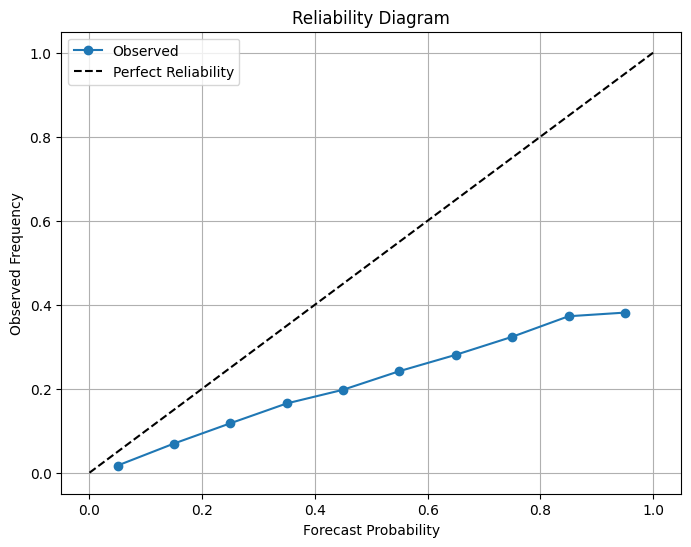

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class ReliabilityDiagram:
    def __init__(self, observation, forecast, nbins=10):
        """
        Initialize the ReliabilityDiagram class.

        Args:
            observation: Array of observed values.
            forecast: Array of predicted probabilities (forecasted values or quantiles).
            nbins: Number of bins to divide the forecast probabilities.
        """
        self.observation = np.array(observation).flatten()
        self.forecast = np.array(forecast).flatten()
        self.nbins = nbins
        self.bins = np.linspace(0, 1, self.nbins + 1)

    def observed_frequency(self):
        """
        Calculate the observed frequency for each bin.

        Returns:
            Array of observed frequencies for each bin.
        """
        # Bin the forecast probabilities
        bin_counts = np.histogram(self.forecast, bins=self.bins)[0]
        # Sum of observations in each bin (weighted histogram)
        obs_sum = np.histogram(self.forecast, bins=self.bins, weights=self.observation)[0]

        # Avoid division by zero
        with np.errstate(divide='ignore', invalid='ignore'):
            obs_freq = np.where(bin_counts > 0, obs_sum / bin_counts, np.nan)
        return obs_freq

    def plot(self):
        """
        Plot the reliability diagram.
        """
        obs_freq = self.observed_frequency()
        bin_centers = (self.bins[:-1] + self.bins[1:]) / 2

        plt.figure(figsize=(8, 6))
        plt.plot(bin_centers, obs_freq, label="Observed", marker="o")
        plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect Reliability", color="black")
        plt.xlabel("Forecast Probability")
        plt.ylabel("Observed Frequency")
        plt.title("Reliability Diagram")
        plt.legend()
        plt.grid()
        plt.show()

# Example usage
# Instantiate and use Reliability Diagram
reliability_diagram = ReliabilityDiagram(
    observation=y_test,  # Observed test values
    forecast=y_pred_quantiles.mean(axis=1),  # Mean of ensemble or quantile predictions
    nbins=10
)
reliability_diagram.plot()


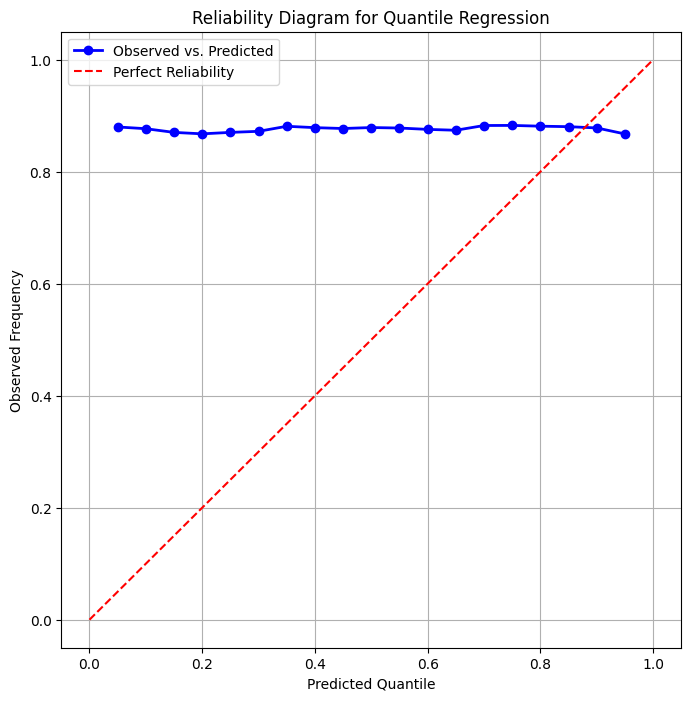

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Observed frequency calculation
def calculate_reliability(predictions, y_true, quantiles):
    """
    Calculate observed frequencies for each quantile.

    :param predictions: Dictionary of predicted quantiles (keys are quantile values, e.g., 0.05, 0.1, ..., 0.95)
    :param y_true: Array of true values.
    :param quantiles: List of quantiles used for predictions.
    :return: List of observed frequencies for each quantile.
    """
    observed_frequencies = []
    y_true = y_true.flatten()  # Flatten true values to 1D

    for tau in quantiles:
        pred_tau = predictions[tau].flatten()  # Predicted quantile for tau
        observed_frequency = np.mean(y_true <= pred_tau)  # Proportion of actuals ≤ predicted
        observed_frequencies.append(observed_frequency)

    return observed_frequencies

# Example Predictions and Quantiles
# Assuming `pred_test` is a dictionary with quantiles as keys and arrays as values
quantiles = np.linspace(0.05, 0.95, 19)  # 20 quantiles (0.05, 0.1, ..., 0.95)

# Example of `pred_test` structure
# pred_test = {0.05: pred_05_array, 0.1: pred_10_array, ..., 0.95: pred_95_array}
# Replace the following line with actual predictions
pred_test = {tau: np.random.rand(len(y_test)) for tau in quantiles}  # Simulated predictions for demo

# Calculate observed frequencies
observed_frequencies = calculate_reliability(pred_test, y_test, quantiles)

# Plot reliability diagram
plt.figure(figsize=(8, 8))
plt.plot(quantiles, observed_frequencies, label="Observed vs. Predicted", color="blue", lw=2, marker="o")
plt.plot([0, 1], [0, 1], "r--", label="Perfect Reliability")  # Diagonal reference line
plt.title("Reliability Diagram for Quantile Regression")
plt.xlabel("Predicted Quantile")
plt.ylabel("Observed Frequency")
plt.legend()
plt.grid(True)
plt.show()
